# Real-Time Machine Learning of Vibration Signals

Paper to be submitted to [IMAC XXXIX](https://sem.org/imac).

#### Notebook Author: Ishrat Singh*
\**correspondence to [ishrat@cec.sc.edu](mailto:ishrat@cec.sc.edu)*

This notebook demonstrates how to use the classes in the `online_models` package for real-time prediction on time series data. Though the class used here is `OnlineMLP`, the same methodology applies for `OnlineLSTM` since both use the methods implemented in `OnlineModelBase` for training and data retrieval.

We first load a dataset from the `data/` folder using `pandas`. The datasets are acceleration signals
that have been experimentally generated using a bench top structural model developed by the [Adaptive Real-Time Systems Laboratory](http://www.me.sc.edu/Research/Downey/) at the University of South Carolina.

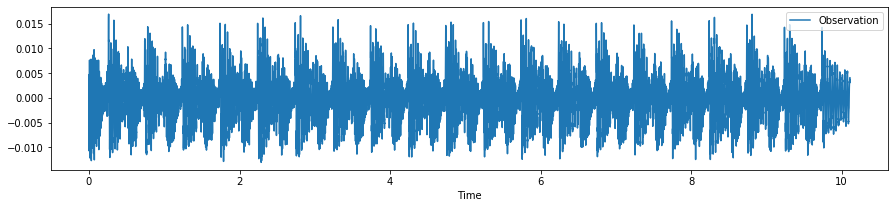

In [1]:
import pandas as pd

series = pd.read_csv('../data/1S_1STD.csv')[['Time', 'Observation']]

series.plot(y='Observation', x='Time', figsize=(15, 3))

Next, we resample the dataset to 5% of its original sample rate using the `resample_time_series` function in `benchmark.helpers`.

Old sample rate: 1651.7117519686772 Hz
New sample rate: 82.74372237746992 Hz


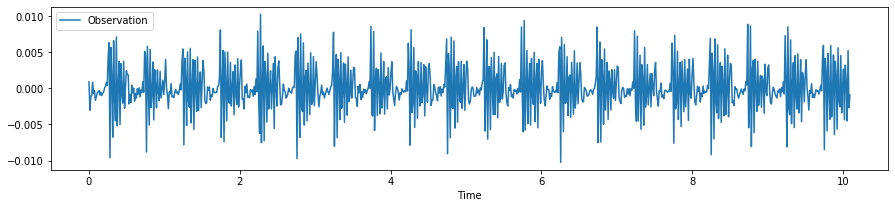

In [2]:
import sys
sys.path.append('..')

from benchmark.helpers import resample_time_series

print(f'Old sample rate: {series.shape[0] / series["Time"].values[-1]} Hz')

resampled, sample_rate = resample_time_series(series, .05)

print(f'New sample rate: {sample_rate} Hz')

resampled.plot(y='Observation', x='Time', figsize=(15, 3))

We then initialize an `OnlineMLP` model and train it on our dataset. `OnlineMLP` accepts a single observation in a time series, making a prediction and updating its internal state each time this is done. Hence, instead of passing in our data as a batch, we feed it each observation one-by-one. Note that the parameters specified are by no means `OnlineMLP`'s optimal parameters for this data (this is discussed in our forthcoming paper), and are just test values.

In [3]:
from online_models import OnlineMLP

ARGS = {
    'history_length': 10,
    'units': [10],
    'epochs': 5,
    'forecast_length': 1,
    'delay': 0,
    'timesteps': resampled.shape[0]
}

onmlp = OnlineMLP(*ARGS.values(), local_rmse_precision=100, verbose=True)

for _, _, obs in resampled.itertuples():
    onmlp.advance_iteration(obs)

Timestep: 835/835

Now, we obtain every prediction the `OnlineMLP` model has made and their corresponding RMSE values. The number of timesteps in the resampled dataset differs from the number of timesteps in the original dataset, so to compensate for this, we rescale the `Timesteps` column using the sample rate of the resampled dataset.

In [4]:
preds = onmlp.to_df().rename(columns={'Timestep': 'Time'})
preds['Time'] = preds['Time'].apply(lambda r: r / sample_rate)

preds.dropna()

,Time,Observed,Predicted,Cumulative RMSE,Local RMSE
11,0.132941,-0.000283,0.000897,0.001180,0.001180
12,0.145026,-0.000925,-0.001345,0.000886,0.000886
13,0.157112,-0.000482,-0.000782,0.000744,0.000744
14,0.169197,-0.000980,0.000252,0.000891,0.000891
15,0.181283,-0.000671,-0.001583,0.000895,0.000895
...,...,...,...,...,...
830,10.030972,0.000802,0.000232,0.003144,0.000661
831,10.043058,-0.004504,-0.002772,0.003142,0.000899
832,10.055143,0.005256,0.004112,0.003141,0.000910
833,10.067229,-0.002669,-0.002154,0.003139,0.000873


From here, we plot the predictions the `OnlineMLP` model has made over their true values.

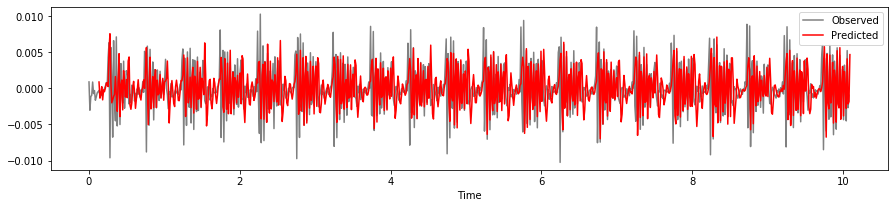

In [5]:
ax1 = preds.plot(y='Observed', x='Time', figsize=(15, 3), color='grey')
preds.plot(y='Predicted', x='Time', ax=ax1, color='red')

We do the same for its RMSE values. The downward trend in `Cumulative RMSE` indicates that the model's accuracy increases over time.

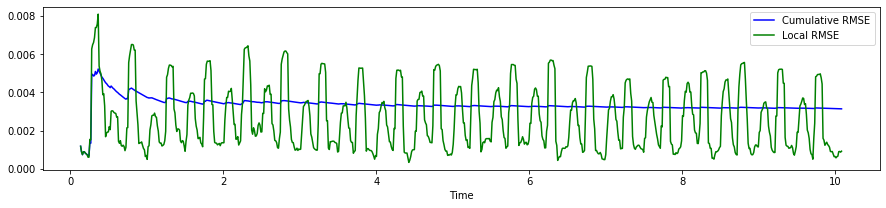

In [6]:
ax2 = preds.plot(y='Cumulative RMSE', x='Time', figsize=(15, 3), color='blue')
preds.plot(y='Local RMSE', x='Time', ax=ax2, color='green')